<a href="https://colab.research.google.com/github/mashby95/Google_Colab/blob/main/Ionic_Liquid_rdkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 54.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import sys
import time
import os
from rdkit import Chem
from rdkit.Chem import rdPartialCharges
from rdkit.Chem import Crippen
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import MolSurf
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools
from rdkit import RDConfig
from rdkit.Chem import rdmolfiles
from rdkit.Chem import rdmolops
from IPython.display import Image, display
import rdkit
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import logging as log
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import pandas as pd

from sklearn.utils import shuffle

In [ ]:
m = Chem.MolFromSmiles('CCCCCCCCCCN1C=C[N+](=C1C)CCCCCCCCCC.[B-](F)(F)(F)F')
rdPartialCharges.ComputeGasteigerCharges(m)
'''for atom in m.GetAtoms():
    atom.SetAtomMapNum(atom.GetIdx())
    print(atom, rdPartialCharges.ComputeGasteigerCharges(m) )'''
adj_matrix = rdmolops.GetAdjacencyMatrix(m)

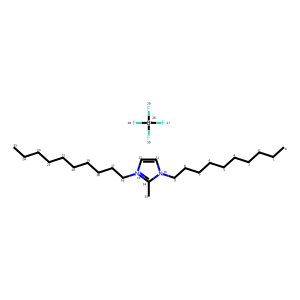

In [ ]:
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300
m

In [ ]:
#Chem.rdmolfiles.MolToXYZFile(m, 'testfile')

In [ ]:
def makeAtomVecMatrix(rdk_mol):
        atoms = rdk_mol.GetAtoms()
        AVM = []
        #returns matrix with atom Vecs for each atom in molecule
        counter = 0
        logP_MR = rdMolDescriptors._CalcCrippenContribs(rdk_mol)
        ASA = list(rdMolDescriptors._CalcLabuteASAContribs(rdk_mol)[0])
        TPSA = rdMolDescriptors._CalcTPSAContribs(rdk_mol)
        for atom in atoms:
            logP, MR  = logP_MR[counter]
            tpsa = TPSA[counter]
            asa = ASA[counter]
            id = int(atom.GetIdx())
            charge = atom.GetDoubleProp('_GasteigerCharge')
            an = atom.GetAtomicNum()
            tv = atom.GetTotalValence()
            AVM.append([id, an, tv, charge, logP, MR, tpsa, asa])
            counter = counter + 1
        return np.array(AVM)

def get_3d_mols(smiles_strs):
    """
    Convert SMILES strings to Mol objects with explicit hydrogens and 3D coordinates

    Args:
        smiles_strs (iterable of str): List of SMILES strings to convert

    Returns:
        tuple (mols, is_valid):
            mols (ndarray of Mol): Mol objects for valid SMILES strings only
            is_valid (ndarray of bool): True for each input SMILES string that was valid according to RDKit

    """
    log.debug('Converting SMILES to RDKit Mols')
    nsmiles = len(smiles_strs)
    mols = [None]*nsmiles
    for i, smi in enumerate(smiles_strs):
        try:
            mols[i] = Chem.MolFromSmiles(smi)
        except TypeError:
            pass

    log.debug('Adding hydrogens to mols')
    mols = [Chem.AddHs(m) if m is not None else None for m in mols]
    log.debug('Computing 3D coordinates')
    for i, m in enumerate(mols):
        if m is not None:
            try:
                AllChem.EmbedMolecule(m)
            except RuntimeError:
                # This sometimes fails in the RDKit code. Give up on this molecule.
                mols[i] = None
    is_valid = np.array([(m is not None) for m in mols], dtype=bool)
    mols = np.array(mols)[is_valid]
    return mols, is_valid

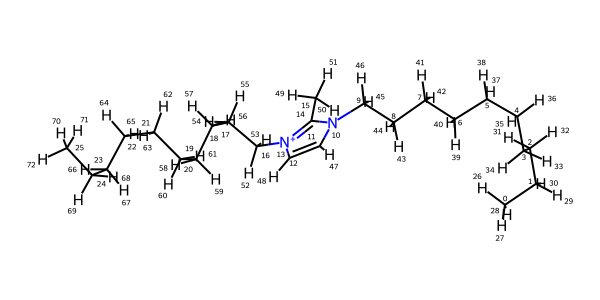

[2.60000000e+01 1.00000000e+00 1.00000000e+00 2.30353325e-02
 1.23000000e-01 1.05700000e+00 0.00000000e+00 1.37075856e+00]
[2.70000000e+01 1.00000000e+00 1.00000000e+00 2.30353325e-02
 1.23000000e-01 1.05700000e+00 0.00000000e+00 1.37075856e+00]
[2.80000000e+01 1.00000000e+00 1.00000000e+00 2.30353325e-02
 1.23000000e-01 1.05700000e+00 0.00000000e+00 1.37075856e+00]
[2.90000000e+01 1.00000000e+00 1.00000000e+00 2.63707569e-02
 1.23000000e-01 1.05700000e+00 0.00000000e+00 1.37075856e+00]
[3.00000000e+01 1.00000000e+00 1.00000000e+00 2.63707569e-02
 1.23000000e-01 1.05700000e+00 0.00000000e+00 1.37075856e+00]
[3.10000000e+01 1.00000000e+00 1.00000000e+00 2.66428768e-02
 1.23000000e-01 1.05700000e+00 0.00000000e+00 1.37075856e+00]
[3.20000000e+01 1.00000000e+00 1.00000000e+00 2.66428768e-02
 1.23000000e-01 1.05700000e+00 0.00000000e+00 1.37075856e+00]
[3.30000000e+01 1.00000000e+00 1.00000000e+00 2.66528183e-02
 1.23000000e-01 1.05700000e+00 0.00000000e+00 1.37075856e+00]
[3.40000000e+01 

In [ ]:
#df = pd.DataFrame()
smiles_list = ['CCCCCCCCCCN1C=C[N+](=C1C)CCCCCCCCCC']
mols = get_3d_mols(smiles_list)
m = m = mols[0][0]
print(m)
rdPartialCharges.ComputeGasteigerCharges(m)
mol_matrix = makeAtomVecMatrix(m)


IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 600,300
display(m)

#df = pd.concat([df, pd.DataFrame(mol_matrix)])
for row in mol_matrix:
  if row[1] == 1:
    print(row)




